In [6]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib nbagg
from chickpea import Waveform, Element, Sequence, Segment

## Introducing: Segments

A segment is part of a 'waveform' which represents a time slice on one channel of waveform generator with up to two markers also specified. Many segments can be put together to make the waveform on one channel. A good example would be to use a segment to specify a gate and then string together many gates on one waveform.

A segment needs:
* a name (optional)
* a generator funtion OR a points_array
* if a generator function is specified then the arguments for this function should be supplied in a dictionary before you can readonably expect to get the points in the function. Sample rate ("SR") will always be one of these
* markers (optional) - These should be given as a dictionary with keys in [1, 2] for marker 1 and 2. If the points were specified in a points array the markers dictionary should spoecified by the raw_markers argument, if a generator function was given the markers can be specified by time_markers or points_markers. For both of these the delay and durations for each 'marker on' should be specified in nested dictionaries (see example below). Whichever you specify will be converted to points markers. 

A segment gives you:
* name (str)
* points (array)
* markers (dict)

### First define some nice functions for segment use

In [7]:
def ramp(start, stop, dur, SR):
    points = int(round(SR * dur))
    return np.linspace(start, stop, points)
    
def gaussian(sigma, sigma_cutoff, amp, SR):
    points = int(SR * 2 * sigma_cutoff * sigma)
    t = np.linspace(-1 * sigma_cutoff * sigma, sigma_cutoff * sigma,
                    num=points)
    return amp * np.exp(-(t**2 / (2 * sigma**2)))

def flat(amp, dur, SR):
    points = int(SR * dur)
    return amp * np.ones(points)

def gaussian_derivative(sigma, sigma_cutoff, amp, SR):
    points = int(SR * 2 * sigma_cutoff * sigma)
    t = np.linspace(-1 * sigma_cutoff * sigma, sigma_cutoff * sigma,
                    num=points)
    return -amp * t / sigma * np.exp(-(t / (2 * sigma))**2)

### Now make some segments

In [8]:
flat_segment = Segment(name='test_flat', gen_func=flat,
                       func_args={'amp':0, 'dur':3, 'SR':10})
ramp_segment = Segment(name='test_ramp', gen_func=ramp,
                       func_args={'start': 0, 'stop':1, 'dur':2, 'SR':10},
                       time_markers={1: {'delay_time':[-0.5], 'duration_time':[1]}})

Segments have length, duration, markers, points etc

In [9]:
ramp_segment.duration

2.0

<IPython.core.display.Javascript object>


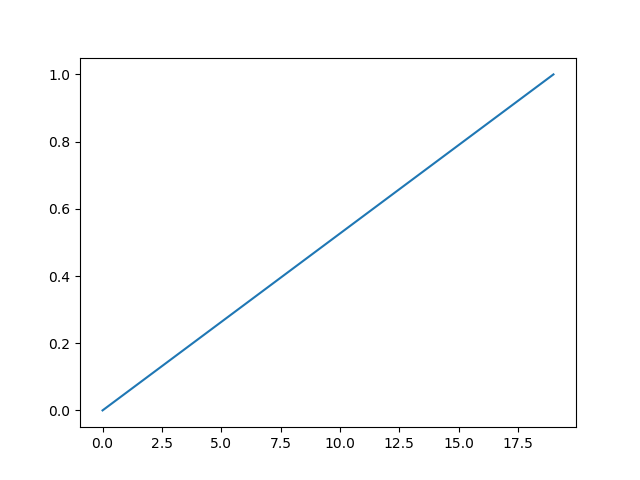

In [10]:
plt.figure()
plt.plot(ramp_segment.points)

It is also possible to add markers to segments and clear all markers on a segment:

In [11]:
flat_segment.add_bound_marker(2, 10, 20)
flat_segment.markers

{1: {'delay_points': [], 'duration_points': []},
 2: {'delay_points': [10], 'duration_points': [20]}}

In [12]:
len(flat_segment)

30

In [13]:
flat_segment.duration

3.0

In [14]:
flat_segment.clear_markers()
flat_segment.markers

{1: {'delay_points': [], 'duration_points': []},
 2: {'delay_points': [], 'duration_points': []}}

## Introducing: Waveforms

A Waveform is made up of a wave and up to 2 markers and represents what runs on one channel of a waveform generator at one time.

A waveform needs:
* a length (optional) to tell it how many points it should have, this can be specified later or generated by adding segments
* a channel (optional) is necessary to set if you want to put the waveform together with others onto an 'element' which is what a multi-channel waveform generator will know about
* a segment_list (optional) can be used to generate the wave but it is also possible to specify the wave manually after waveform creation.
* a sample_rate (optional) is useful if you want to add lots of segments and don't want to bother setting their sample rates individually

A waveform gives you:
* wave (an array)
* markers (a dict of arrays)
* channel (int)

In [15]:
test_wf = Waveform(segment_list=[flat_segment, ramp_segment, flat_segment])

In [16]:
test_wf.sample_rate

<IPython.core.display.Javascript object>


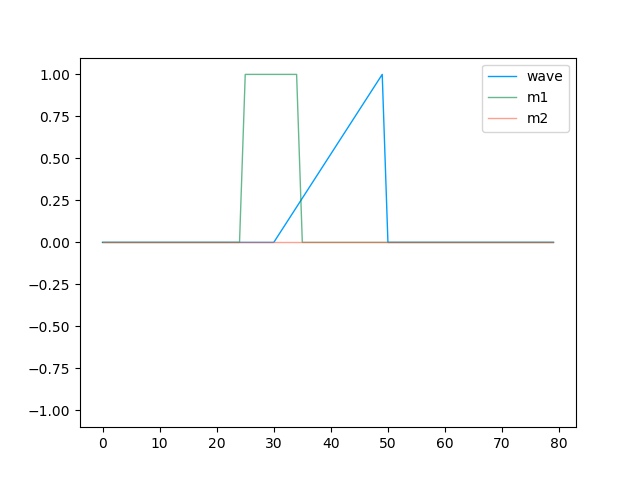

In [17]:
pl = test_wf.plot()

Waveforms also have length and (if you have set the sample rate) duration. Setting the sample rate will set the "SR" func_arg on all segments in the waveform.

Markers can be added manually and cleared (either the ones bound to the waveform or all markers on segment and waveform).

Segments can be added.

In [18]:
test_wf.add_segment(flat_segment)

In [19]:
test_wf.add_marker(1, 0, 10)

In [20]:
test_wf.channel = 2

In [21]:
test_wf.clear_wave_markers()

In [22]:
test_wf.clear_all_markers()

<IPython.core.display.Javascript object>


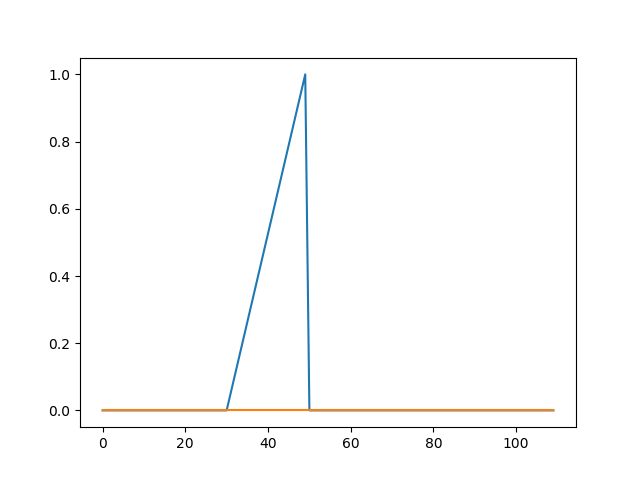

In [23]:
plt.figure()
plt.plot(test_wf.wave)
plt.plot(test_wf.markers[1])

lets make a few spares (using the raw points method rather then segment list) to use later

In [24]:
another_test_wf = Waveform(length=len(test_wf), channel=1)
another_test_wf.wave[0:20] = 1

In [25]:
yet_another_test_wf = Waveform(length=len(test_wf), channel=1)
yet_another_test_wf.wave[20:40] = 1

the_last_test_wf = Waveform(length=len(test_wf), channel=2)
the_last_test_wf.wave[50:60] = 1
the_last_test_wf.add_marker(2, 10, 15)

<IPython.core.display.Javascript object>


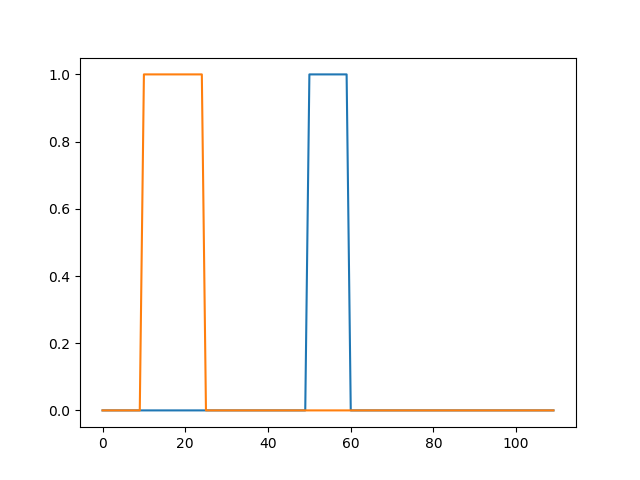

In [26]:
plt.figure()
plt.plot(the_last_test_wf.wave)
plt.plot(the_last_test_wf.markers[2])

### Introducing: Elements

An element is a bunch of waveforms which run simultaneously on different channels of the waveform generator. Hence it is just a dictionary of the waveforms with the channels as keys.

An element needs:
* nothin really, its chill
* sample_rate (optional) handy if you want to set the sample_rate of all the waveforms at once and then get it later

An element gives you:
* waveforms. In fact it should be used just like a dictionary
* duration (if you set the sample rate)

In [27]:
test_element = Element()
test_element.add_waveform(test_wf)
test_element.add_waveform(another_test_wf)
test_element

{1: <chickpea.waveform.Waveform object at 0x10dadba20>, 2: <chickpea.waveform.Waveform object at 0x10d2f8e80>}

Let's make a spare for later

In [28]:
another_test_element = Element()
another_test_element.add_waveform(yet_another_test_wf)
another_test_element.add_waveform(the_last_test_wf)
test_element

{1: <chickpea.waveform.Waveform object at 0x10dadba20>, 2: <chickpea.waveform.Waveform object at 0x10d2f8e80>}

### Introducing: Sequences

A sequence is a list of elements which should be executed one after another on the waveform generator. This is pretty useful if you have an AWG4014C (and really how could you not) and want to use sequencing mode which is much faster than manually stepping through elements. It's also good for things like varying one parameter on one waveform because you can just make a sequence where the only difference between the elements is the value of that one parameter.

A sequence needs:
* a name (optional)
* a variable (optional) - This is useful if you want to vary one param across the sequence as mentioned above, this way you can easily ask the sequence what it varied across it's elements
* a variable_label (optional) - Good for labeling axes ;)
* a variable_unit (optional) - As above
* start (optional) is the start value of the variable specified which is used together with stop to make a 'variable_array' which you can use however you would like but I use to specify what changed throughout the sequence
* stop (optional) is used with 'start' to make the 'variable_array'
* step (optional) is the step size of the variable array
* nreps (default 1) is the number of times you want each element played before going to the next element
* trig_waits (default 0) is whether or not you want the elements to wait for a trigger
* goto_states (default 'the next element') is which element you want up next
* jump_tos (default 'the first element') is where you want to go if there is an 'event'. Don't ask
* labels (optional) is any other metadata you want to stick on the sequence in dict form

A sequence gives you:
* a nice list of elements :) it's basically just a list with bells
* a variable_array (see above)
* a method for 'unwrapping' your element list into a format which your waveform generator wants to suck up and play

In [29]:
test_seq = Sequence(name='test_seq')
test_seq.add_element(test_element)
test_seq.add_element(another_test_element)
test_seq

[{1: <chickpea.waveform.Waveform object at 0x10dadba20>, 2: <chickpea.waveform.Waveform object at 0x10d2f8e80>}, {1: <chickpea.waveform.Waveform object at 0x10dacd358>, 2: <chickpea.waveform.Waveform object at 0x10dacd278>}]

<IPython.core.display.Javascript object>


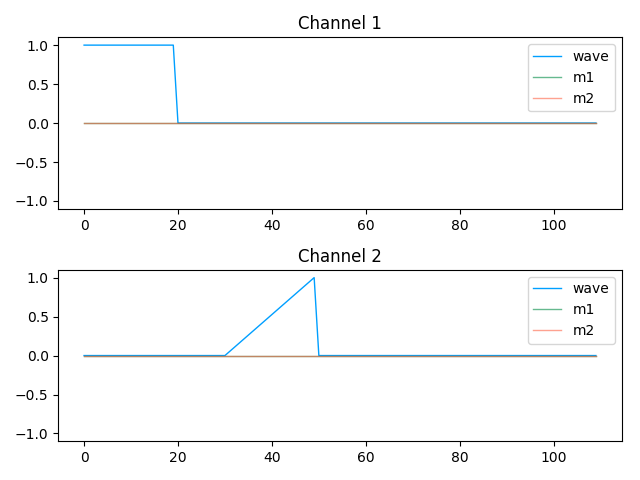

<IPython.core.display.Javascript object>


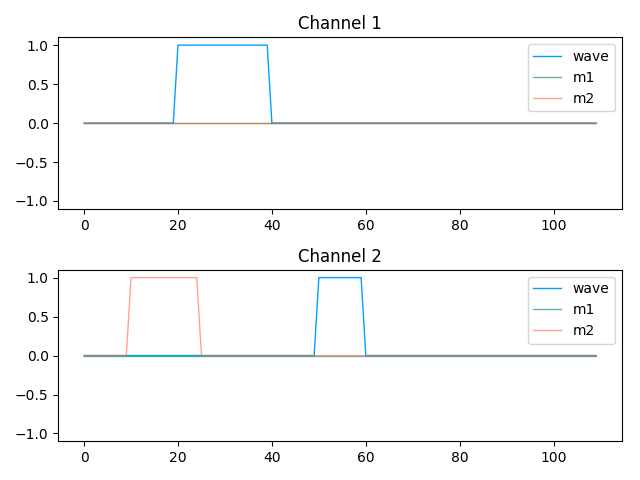

In [30]:
pl = test_seq.plot(elemnum=0)
pl2 = test_seq.plot(elemnum=1)

Great, so that worked. I know I didn't use much of the 'varying a parameter in a sequence part' but head over to one of the other example notebooks for some examples of that and in the meantime let's wrap up with a quick demo of uploading to our favourite AWG5014C using QCoDeS (also our favourite).

### Upload and Play

In [31]:
import qcodes as qc
import qcodes.instrument_drivers.tektronix.AWG5014 as awg
awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP0::172.20.3.170::inst0::INSTR', timeout=40)

ImportError: No module named 'qcodes'

In [32]:
awg1.make_send_and_load_awg_file(*test_seq.unwrap())

NameError: name 'awg1' is not defined

In [ ]:
awg1.ch1_state(1)
awg1.ch2_state(1)
awg1.run()

In [4]:
wf = Waveform(length=10)

In [7]:
wf.wave

array([ 0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.])